In [1]:
# First poroelastic functions are computed to set values for the analytical solution

a = 1 # Biot modulus
Kf = 2.2E09 # Bulk modulus water
phi = 0.2 # Porosity
nu = .25 # Poissons ratio
K = 1E10 # Drained bulk modulus

def Skempton_coefficient(a, Kf, phi, K):
    params = (a*Kf)/((a-phi*(1-a))*Kf + phi*K)
    return params

def Biot_modulus(phi, Kf, K):
    params = (phi / Kf) + ((1 - a) * (a - phi)) / (K)
    return params
    
def Undrained_bulk_modulus(K, a, M):
    params = K + (a**2) * M
    return params

def shear_modulus(K, nu):
    params = (3 * K * (1 - 2 * nu)) / (2 * (1 + nu))
    return params

def Undrained_Poisson(Ku, G):
    params = (3 * Ku - 2 * G) / (2 * (3 * Ku + G))
    return params

def Barometric_efficiency(B, nu_u):
    params = B * (1+nu_u)/(3*(1-nu_u))
    return params

def Barometric_efficiency_2D(B, nu_u):
    params = 2* B * (1+nu_u)/3
    return params

B = Skempton_coefficient(a, Kf, phi, K)
M = 1 / Biot_modulus(phi, Kf, K)
Ku = Undrained_bulk_modulus(K, a, M)
G = shear_modulus(K, nu)
nu_u = Undrained_Poisson(Ku, G)
y = Barometric_efficiency(B, nu_u)

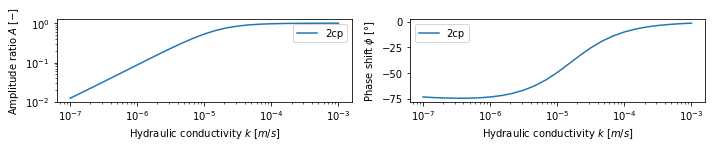

In [2]:
from scipy.special import kv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

###
# Phython script to that solves for the analytical solution of Wang found in this paper.
# Wang, C. Y., Doan, M. L., Xue, L., & Barbour, A. J. (2018). Tidal response of groundwater in a leaky aquifer—Application to Oklahoma. Water Resources Research, 54(10), 8019-8033.

# This code plots the figure found in the paper to validate the analytical solution
# Conductivity range -7 to -3 m/s; 
# No leaky layer
# Specific storage 1E-6 1/m. As the Biot coeff is one. We control specific storage with the porosity
# This solution is the same as Hsieh when no leakage is set!
###

# Variables
R_W = 0.2 # well radius m
R_C = 0.2 # well case m
R = 0.2 # distance from the well m (only for drawdown computation)

PERIOD = np.array([1]) * 24 * 3600 / 2 # frequency:2cp - [s] This is an array cause can be used to compute more frequencies

K_AQ = np.logspace(-7,-3, 25) # HC bottom m/s
K_LE = 0 # HC top m/s NO LEAKAGE!

B_AQ = 1 # Aquifer depth m
B_LE = 100 # Leaky layer depth m

S_AQ = 1.1E-4 # Specific storage [-]: i.e = 1E-6 * (B_LE + B_AQ)

SKEMPTON = 0.5 # Skempton's coefficient [-]
BULK = Ku # Undrained bulk modulus [Pa] (computed in the above cell) 

E_0 = 1E-8 # Signal amplitude [-] 

# Functions
def omega_fn(PERIOD):
    params = 2 * np.pi / PERIOD
    return params

def betta_fn(K_LE, K_AQ, B_AQ, B_LE, omega, S_AQ):
    params = ((K_LE / (K_AQ * B_AQ * B_LE)) + ((1j * omega * S_AQ * B_AQ) / (K_AQ * B_AQ))) ** 0.5
    return params

def argument_fn(omega, S_AQ, B_AQ, K_LE, B_LE):
    params = (1j * omega * S_AQ * B_AQ) / (1j * omega * S_AQ * B_AQ + K_LE / B_LE)
    return params

def tide_fn(SKEMPTON, BULK, E_0):
    params = (SKEMPTON * BULK * E_0) / 1E4
    return params

def xi_fn(R_W, R_C, omega, K_AQ, B_AQ, betta):
    params = 1 + ((1j * omega * R_W) / (2 * K_AQ * B_AQ * betta)) * (kv(0, betta * R_W) / kv(1, betta * R_W)) * (R_C / R_W)**2
    return params

def h_w_fn(argument, tide, xi):
    params = argument * tide / xi
    return params

def drawdown_fn(omega, R_C, h_w, betta, K_AQ, B_AQ, R):
    params = -(1j * omega * R_C ** 2 * h_w * kv(0, betta * R)) / (2 * K_AQ * B_AQ * betta * R_W * kv(1, betta * R))
    return params

def flux_fn(omega, h_w,  R_C):
    params = omega * np.absolute(h_w) * np.pi * R_C**2 *1E3
    return params

# Empty array to save solutions
h_w = np.zeros((len(PERIOD), len(K_AQ)), dtype = 'complex_') # Well drawdown
A = np.zeros_like(h_w) # Amplitude ratio
phi = np.zeros_like(h_w) # Time shift
drawdown = np.zeros_like(h_w) # Aquifer drawdwon
flux = np.zeros((len(PERIOD), len(K_AQ))) # Well flux amplitude

for i, p in enumerate(PERIOD):
    
    # Over the functions
    omega = omega_fn(p)
    betta = betta_fn(K_LE, K_AQ, B_AQ, B_LE, omega, S_AQ)
    argument = argument_fn(omega, S_AQ, B_AQ, K_LE, B_LE)
    tide = tide_fn(SKEMPTON, BULK, E_0)
    xi = xi_fn(R_W, R_C, omega, K_AQ, B_AQ, betta)
    
    # Save solutions in arrays
    h_w[i,:] = h_w_fn(argument, tide, xi)
    drawdown[i,:] = np.absolute(drawdown_fn(omega, R_C, h_w[i,:], betta, K_AQ, B_AQ, R))
    A[i,:] = np.absolute(h_w[i,:] / tide)
    phi[i,:] = np.angle(h_w[i,:] / tide, deg=True)
    flux[i,:] = (flux_fn(omega, h_w[i,:],  R_C))
    
# Now we save this solution in a CSV so can be used to verify our numerical model later
df = pd.DataFrame({"perm" : K_AQ, "amplitude_2cp" : A[0,:].real, "time_shift_2cp" : phi[0,:].real})
df.to_csv("Wang_solution.csv", index=False)
    
###
# Make the figure (just plotting here)
### 
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 2))

ax1.plot(K_AQ, np.real(A[0,:]), label = '2cp')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel('Hydraulic conductivity $k$ [$m/s$]')
ax1.set_ylabel('Amplitude ratio $A$ [$-$]')
ax1.legend()

ax2.plot(K_AQ, np.real(phi[0,:]), label = '2cp')
ax2.set_xlabel('Hydraulic conductivity $k$ [$m/s$]')
ax2.set_ylabel('Phase shift $\phi$ [$°$]')
ax2.legend()
ax2.set_xscale('log')

fig.tight_layout()

In [3]:
# We would like to compare the analytical solution with our MOOSE model, to make sure that the 
# geomechanical coupling and assumed BC acctually works. Also this will guide us to find the best 
# mesh set up.

# We generate MOOSE input files to simulate numerically Wang's solution. To do so, we start with a "base file"
# named wang_ts.i and we will edits its material properties (hydraulic conductivity) and sink flux to fit 
# Wang's solution.

# Note that for this simulation we wont change the steady solution since only permeability is changing.

# path to the base file (this may change depending on your set up)
# path to base file
base_path =  # Your path to file

# path where input files will be storaged
sim_path = 'Sim_files'# Your path to sim files

# Generate permeability values
import numpy as np

# Generate permeability values
P_AQ = np.logspace(-7, -3, 9) * 1E-7

# Generate flux fun values
flux_fn = np.logspace(-2, -2, 9)

# Generate dt max
dt = np.array([1000, 500, 500, 300, 300, 200, 200, 100, 100])

# Generate sim time
time = np.array([1728000, 691200,  691200, 259200, 259200, 86400, 86400, 86400, 86400])*5

# We want to study two typical Earth tide period 2cp
PERIOD = np.array([1]) * 24 * 3600 / 2 # s

# To study the effect of the Biot Modulus we also simulate discrete values. Generally the Biot modulus is between 0 and 1
Biot = np.linspace(1,1,1)

for n in Biot:
    for i, p in enumerate(PERIOD):
        for k, j in enumerate(range(len(P_AQ))):

            # Read in the file
            with open(base_path + '/wang_ts.i', 'r') as file:
                filedata = file.read()

            # Replace the target string
            filedata = filedata.replace("permeability = '1.0E-10 0 0 0 0 0 0 0 0'", "permeability = '" + str(P_AQ[k]) + " 0 0 0 0 0 0 0 0'")
            filedata = filedata.replace('flux_function = 1E-2', 'flux_function = ' + str(flux_fn[k]))
            filedata = filedata.replace('dtmax = 100', 'dtmax = ' + str(dt[k]))
            filedata = filedata.replace('file_base = gold/wang_ts', 'file_base = gold/' + str(k) + '_' + str(n))
            filedata = filedata.replace('end_time = 864000.0', 'end_time = ' + str(time[k]))
            filedata = filedata.replace('  biot_coefficient = 1', '  biot_coefficient = ' + str(n))
            
            # Write the file out again
            with open(sim_path + '/' + str(k) + '_' + str(n) + '.i', 'w') as file:
                file.write(filedata)

Perform your simulations in MOOSE

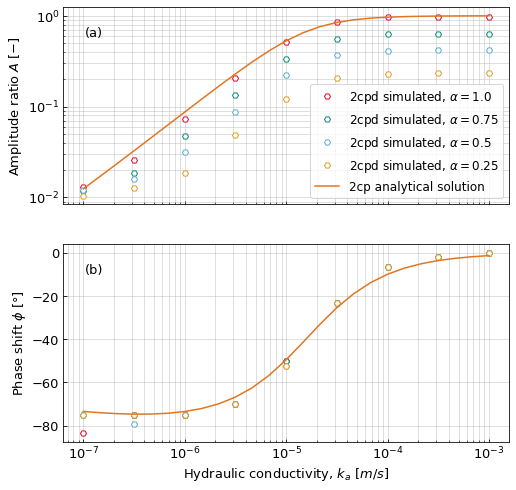

In [5]:
from scipy.interpolate import interp1d
from scipy.optimize import leastsq
from scipy.signal import find_peaks
from scipy import signal, fftpack
import pandas as pd
import matplotlib.pyplot as plt
myColor  = ("#E3072A","#0A8974","#5FAECC","#E49C23","#E27520") # Darjeeling Color map
plt.rcParams.update({'font.size': 13})

sim_amplitude = np.zeros((len(PERIOD), len(P_AQ))) # MOOSEs amplitude
sim_shift = np.zeros_like(sim_amplitude) # MOOSEs time shift

biot = ['1.0', '0.75', '0.5','0.25']
dic = {}

for n in biot:
    for j in range(len(PERIOD)):
        for k in range(9):
            df = pd.read_csv(sim_path + '/gold/' + str(k) + '_' + n + '.csv')

            # Find the peaks to manualy compute amplitude and shift

            Y = df.tidal_head /(0.2/2.2E9) # Original strain signal
            Y_shifted = df.wellPP[1:]-df.wellPP[1] # Well signal

            peaks, _ = find_peaks(-Y, height=0) # Peak of the signal (equals the amplitude, but anyways)

            # Happens that at low conductivity the signal sifts bc of dynamics. So I think
            # that is better to find top and bottom peak and take the distance between them.
            # Here I find the peaks
            peaks_shifted, _ = find_peaks(Y_shifted, height=0) # Possitive peak
            peaks_shifted_b, _ = find_peaks(-Y_shifted, height=0) # Negative peak

            # Here I find the distance
            peaks_diff = (abs(Y_shifted[peaks_shifted[-1]]) + abs(Y_shifted[peaks_shifted_b[-1]]))/2

            # Compute amplitude
            sim_amplitude[j,k] = abs(peaks_diff) / abs(Y[peaks[-1]])

            # Find shift between signals
            found_shift = peaks_shifted_b[-1] - peaks[-1]

            # Compuite the shift
            sim_shift[j,k] = found_shift * -dt[k] * 360 / PERIOD[j] # Time shift in degrees is delta t * 360 / period
    dic[n] = np.vstack((sim_amplitude[0,:],sim_shift[0,:]))
    
# Read analytical solution
df_analytic = pd.read_csv('Wang_solution.csv')

# Plot results MOOSEs vs analytical
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8, 8), sharex=True)

labels = ['2cp analytical solution']
labels_MOOSE = ['2cpd simulated']

for i, n in enumerate(biot):
    ax1.plot(P_AQ * 1E7, dic[n][0,:], 'H', label = labels_MOOSE[0] + ', $α=$' + n, markerfacecolor='w',color=myColor[i])
    ax2.plot(P_AQ * 1E7, dic[n][1,:], 'H', label = labels_MOOSE[0] + ', $α=$' + n, markerfacecolor='w',color=myColor[i])

ax1.plot(df_analytic.perm, df_analytic.amplitude_2cp, label = labels[0],color=myColor[i+1])
ax2.plot(df_analytic.perm, df_analytic.time_shift_2cp, label = labels[0],color=myColor[i+1])
  
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_ylabel('Amplitude ratio $A$ [$-$]')
ax1.legend(fontsize=12)
ax1.grid(True, which="both", alpha=0.5)
ax2.set_xlabel('Hydraulic conductivity, $k_a$ [$m/s$]')
ax2.set_ylabel('Phase shift $\phi$ [$°$]')
ax2.set_xscale('log')
ax2.grid(True, which="both", alpha=0.5)

ax1.xaxis.set_tick_params(direction='in', which='both')
ax1.yaxis.set_tick_params(direction='in', which='both')
ax2.xaxis.set_tick_params(direction='in', which='both')
ax2.yaxis.set_tick_params(direction='in', which='both')

ax1.annotate('(a)', xy=(0.05, 0.85), xycoords='axes fraction')
ax2.annotate('(b)', xy=(0.05, 0.85), xycoords='axes fraction')
fig.savefig("Figure_6.pdf")